In [94]:
import os
import pandas as pd
import numpy as np
import sys
from pathlib import Path
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import seaborn as sns

REPO_ROOT = Path("/Users/lisawalker/Workspace/urban-weather-air-quality-etl-pipeline")
NOTEBOOK_DIR = Path(__file__).resolve().parent if "__file__" in globals() else REPO_ROOT / "notebooks"
PROJECT_ROOT = NOTEBOOK_DIR.parent  # parent of notebooks/, i.e., the repo root

if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

os.chdir(PROJECT_ROOT)
DATA_PATH = PROJECT_ROOT / "UrbanAirQualityandHealthImpactDataset.csv"

from src.extract import extract_weather_data
from src.transform import transform_data
from src.load import create_database_engine, load_data_into_database_table, read_existing_table

load_dotenv()

DATABASE_URL = os.getenv('DATABASE_URL')
if not DATABASE_URL:
    raise ValueError("Database URL is not set in the .env file")

# Extract Weather & Air Quality Data

In [95]:
# Extract data from CSV
df = extract_weather_data()

# Transform the Data

Clean the data up (replace missing values, etc.), grab the specific data for weather

In [96]:
# Transform data, only need to grab weather data
weather_df, _ = transform_data(df)

# Load the Transformed Data into PostgreSQL Database Table

In [97]:
# Load data into database
DATABASE_URL = os.getenv('DATABASE_URL')
engine = create_database_engine(DATABASE_URL)
load_data_into_database_table(weather_df, 'weather', engine)
result = read_existing_table('weather', engine)
print("Weather data preview: \n", result.head())
print("Weather data shape: ", result.shape)

Weather data preview: 
     datetime  datetimeEpoch  tempmax  tempmin  temp  feelslikemax  \
0 2024-09-07   1.725692e+09    106.1     91.0  98.5         104.0   
1 2024-09-08   1.725779e+09    103.9     87.0  95.4         100.5   
2 2024-09-09   1.725865e+09    105.0     83.9  94.7          99.9   
3 2024-09-10   1.725952e+09    106.1     81.2  93.9         100.6   
4 2024-09-11   1.726038e+09    106.1     82.1  94.0         101.0   

   feelslikemin  feelslike   dew  humidity  ...               icon  \
0          88.1       95.9  51.5      21.0  ...  partly-cloudy-day   
1          84.7       92.3  48.7      21.5  ...          clear-day   
2          81.6       90.6  41.7      16.9  ...          clear-day   
3          79.5       89.8  39.1      15.7  ...          clear-day   
4          80.0       90.0  40.1      15.9  ...          clear-day   

                            stations  source     City  Temp_Range  Heat_Index  \
0  ['KSDL', 'KDVT', 'AZM15', 'KPHX']    comb  Phoenix      

# Weather Data Facts, Analysis, and Visualizations

The rest of this notebook contains various analysis approaches and visualization ideas for the weather data facts.

## Summary of Weather Statistics by City

In [98]:
# Summary of statistics by city
summary_stats = (
    weather_df.groupby('City')[['temp', 'humidity', 'precip', 'windspeed']]
      .agg(['mean', 'std', 'min', 'max'])
)

# Flatten the column MultiIndex for easier styling/labeling
summary_stats.columns = [
    f"{metric.capitalize()} ({stat.title()})"
    for metric, stat in summary_stats.columns
]
summary_stats = summary_stats.round(2)

value_cols = list(summary_stats.columns)

styled_city_stats = (
    summary_stats.style
        .background_gradient(cmap='RdYlGn_r', subset=value_cols)
        .set_properties(**{'font-size': '12px', 'text-align': 'center'})
        .set_table_styles([
            {'selector': 'th', 'props': 'background-color:#0a0a0a; font-weight:bold; text-align:center;'},
            {'selector': 'tbody tr:nth-child(even)', 'props': 'background-color:#fafafa;'}
        ])
        .set_caption('Weather Summary Statistics by City')
)

styled_city_stats

,Temp (Mean),Temp (Std),Temp (Min),Temp (Max),Humidity (Mean),Humidity (Std),Humidity (Min),Humidity (Max),Precip (Mean),Precip (Std),Precip (Min),Precip (Max),Windspeed (Mean),Windspeed (Std),Windspeed (Min),Windspeed (Max)
City,,,,,,,,,,,,,,,,
Chicago,73.350000,6.450000,55.550000,80.860000,52.980000,6.820000,36.340000,69.550000,0.010000,0.020000,-0.020000,0.070000,9.840000,2.880000,6.690000,19.020000
Dallas,80.900000,6.220000,70.460000,90.660000,56.280000,13.470000,39.540000,84.230000,0.040000,0.100000,-0.020000,0.470000,10.200000,3.240000,5.590000,17.920000
Houston,81.080000,2.990000,76.380000,86.960000,70.770000,11.340000,51.390000,92.460000,0.110000,0.120000,-0.010000,0.360000,11.060000,2.950000,5.970000,18.770000
Los Angeles,71.050000,8.550000,61.010000,89.300000,57.070000,16.420000,32.910000,87.420000,0.000000,0.010000,-0.010000,0.020000,8.320000,1.310000,5.450000,11.020000
New York City,71.200000,3.590000,60.760000,77.860000,62.000000,7.330000,50.360000,82.120000,0.090000,0.150000,-0.010000,0.450000,9.840000,1.840000,6.180000,14.170000
Philadelphia,70.590000,4.080000,60.130000,77.600000,61.880000,6.530000,49.500000,79.190000,0.030000,0.050000,-0.010000,0.240000,8.040000,2.840000,4.890000,14.220000
Phoenix,91.770000,3.190000,84.850000,99.850000,20.960000,7.160000,11.750000,41.490000,0.000000,0.010000,-0.020000,0.030000,9.920000,3.360000,5.040000,18.770000
San Antonio,82.070000,3.090000,75.000000,87.760000,59.350000,9.300000,42.170000,77.910000,0.040000,0.060000,-0.010000,0.250000,11.890000,3.280000,6.820000,18.730000
San Diego,70.590000,5.450000,64.080000,81.450000,72.000000,7.450000,59.520000,88.180000,0.000000,0.010000,-0.020000,0.040000,10.230000,1.080000,8.050000,12.840000


## Temperature

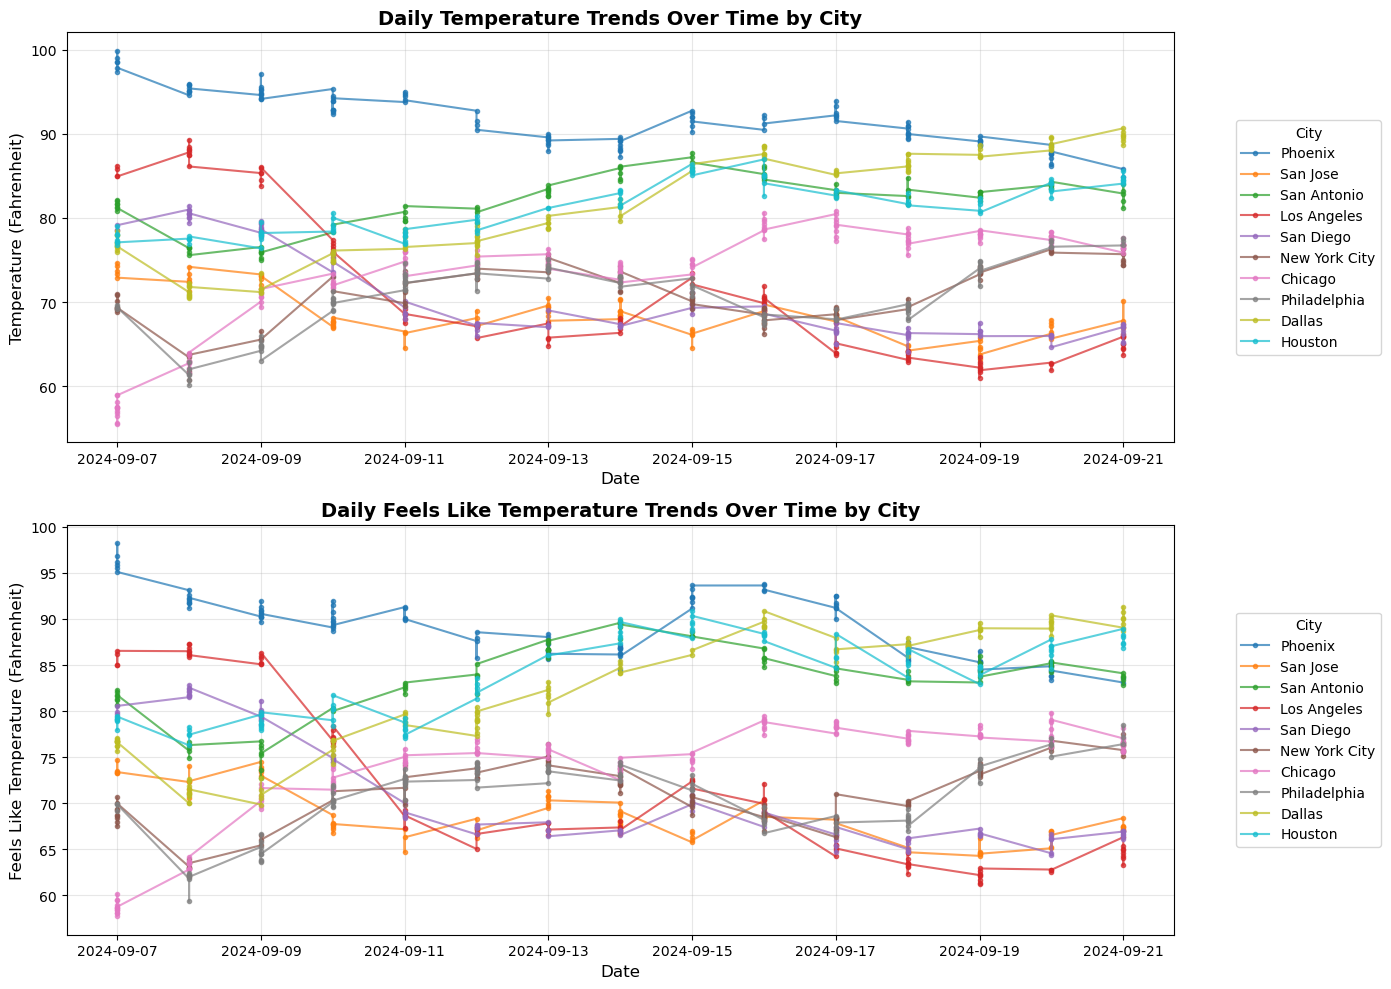

In [99]:
# Time series plots: Temperature over time by city
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Plot 1: Temperature over time
for city in weather_df['City'].unique():
    city_data = weather_df[weather_df['City'] == city].sort_values('datetime')
    axes[0].plot(city_data['datetime'], city_data['temp'], 
                 label=city, marker='o', markersize=3, alpha=0.7)

axes[0].set_title('Daily Temperature Trends Over Time by City', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Date', fontsize=12)
axes[0].set_ylabel('Temperature (Fahrenheit)', fontsize=12)
axes[0].legend(title='City', loc='center left', bbox_to_anchor=(1.05, 0.5))
axes[0].grid(True, alpha=0.3)

# Plot 2: Feels like Temperature over same time period
for city in weather_df['City'].unique():
    city_data = weather_df[weather_df['City'] == city].sort_values('datetime')
    axes[1].plot(city_data['datetime'], city_data['feelslike'], 
                 label=city, marker='o', markersize=3, alpha=0.7)

axes[1].set_title('Daily Feels Like Temperature Trends Over Time by City', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Date', fontsize=12)
axes[1].set_ylabel('Feels Like Temperature (Fahrenheit)', fontsize=12)
axes[1].legend(title='City', loc='center left', bbox_to_anchor=(1.05, 0.5))
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

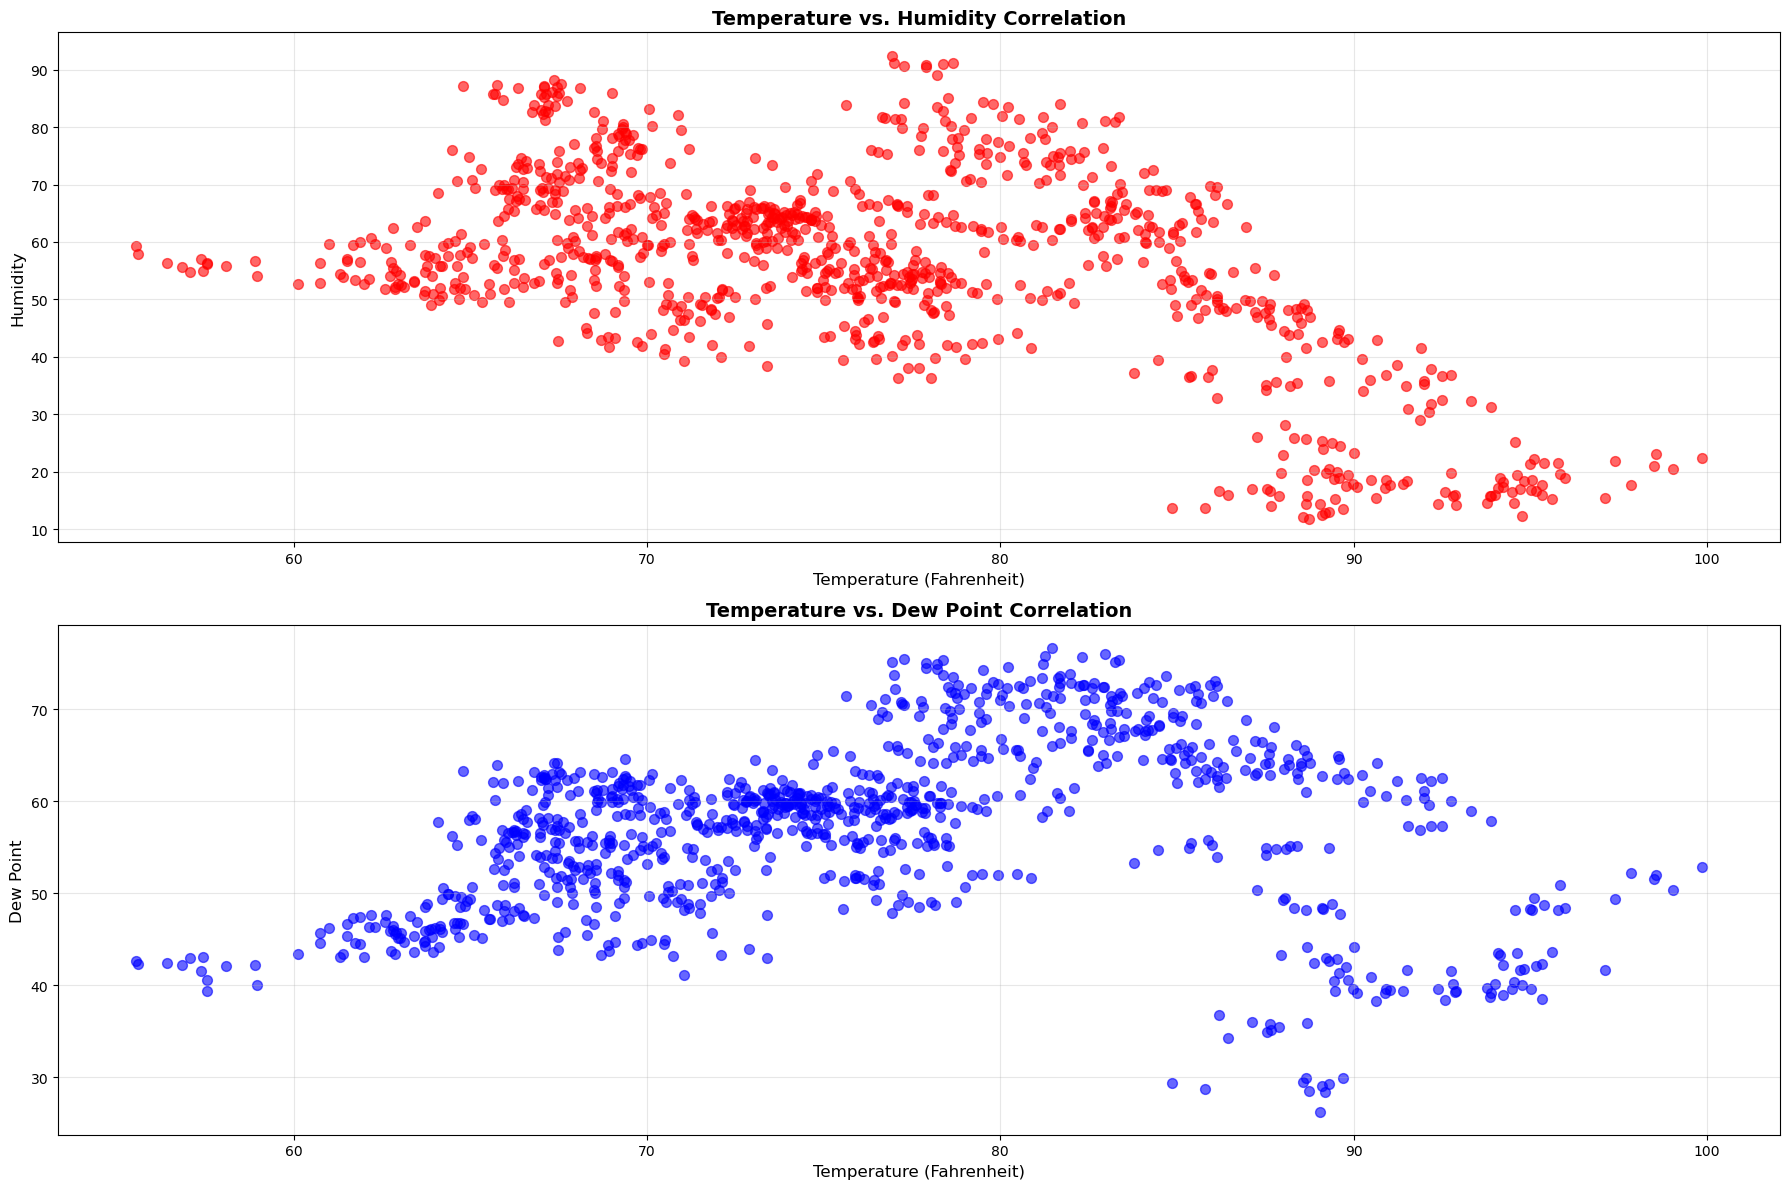

In [100]:
# Correlation plots: Temperature compared to humidity/dew point
fig, axes = plt.subplots(2, 1, figsize=(18, 12))

# Plot 1: Temperature vs. Humidity Relationship
scatter = axes[0].scatter(weather_df['temp'], weather_df['humidity'], 
                    c='red', alpha=0.6, s=50)
axes[0].set_xlabel('Temperature (Fahrenheit)', fontsize=12)
axes[0].set_ylabel('Humidity', fontsize=12)
axes[0].set_title('Temperature vs. Humidity Correlation', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Plot 2: Temperature vs. Dew Relationship
scatter = axes[1].scatter(weather_df['temp'], weather_df['dew'], 
                    c='blue', alpha=0.6, s=50)
axes[1].set_xlabel('Temperature (Fahrenheit)', fontsize=12)
axes[1].set_ylabel('Dew Point', fontsize=12)
axes[1].set_title('Temperature vs. Dew Point Correlation', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## Precipitation

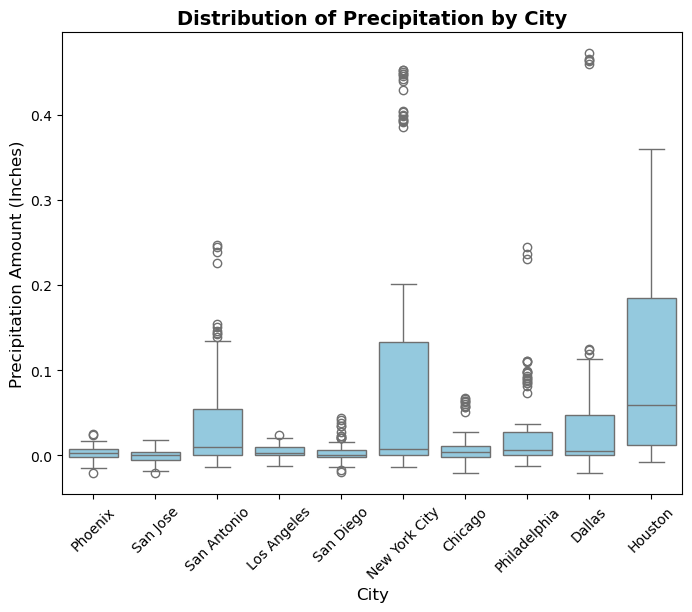

In [101]:
# Precipitation Distribution by City

# Box Plot w/ outlier detection for extreme rainfall events
fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(data=weather_df, x='City', y='precip', color='skyblue')
ax.set_title('Distribution of Precipitation by City', fontsize=14, fontweight='bold')
ax.set_xlabel('City', fontsize=12)
ax.set_ylabel('Precipitation Amount (Inches)', fontsize=12)
ax.tick_params(axis='x', rotation=45)

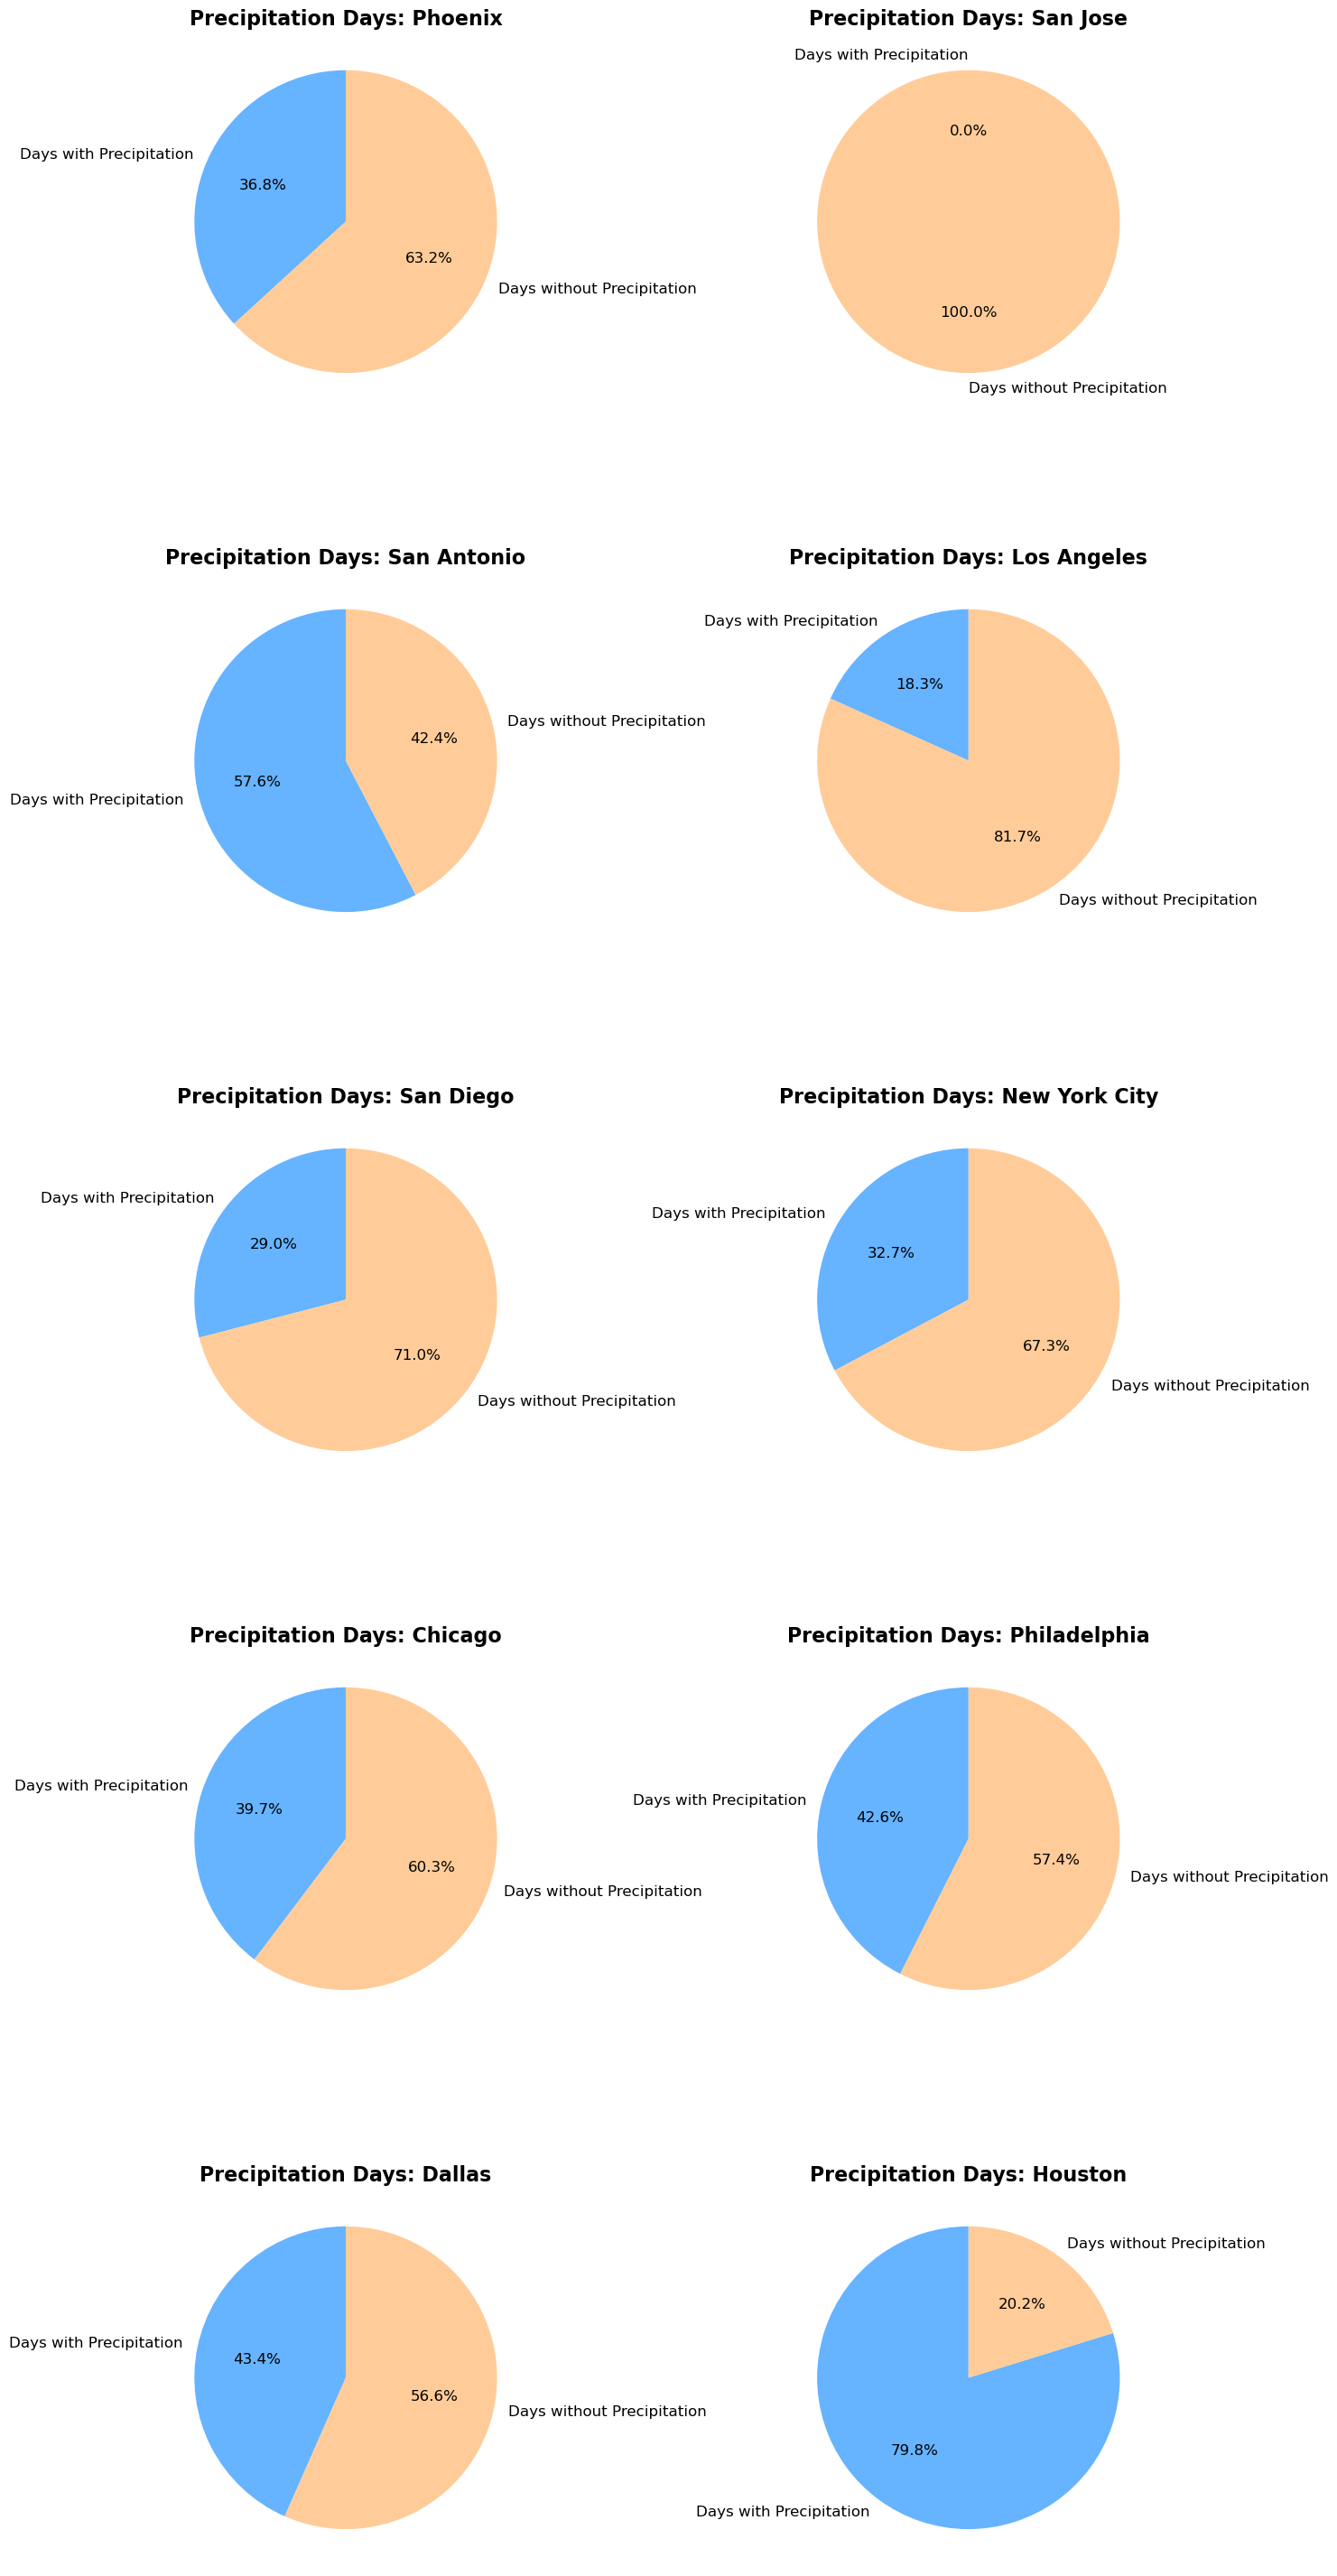

In [102]:
# Proportion of days with vs. without precipitation

# Pie Chart for each city
cities = weather_df['City'].unique()
n_cities = len(cities)

# Calculate number of subplots needed (arrange in a grid)
n_cols = 2
n_rows = (n_cities + n_cols - 1) // n_cols  # Ceiling division

fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 6 * n_rows))
axes = axes.flatten() if n_cities > 1 else [axes] if n_rows == 1 else axes

for idx, city in enumerate(cities):
    city_data = weather_df[weather_df['City'] == city]
    
    # Count days with precipitation based on preciptype (not 'None' or NaN) vs without
    days_with_precip = (~city_data['preciptype'].isin(['None', None]) & city_data['preciptype'].notna()).sum()
    days_without_precip = (city_data['preciptype'].isin(['None', None]) | city_data['preciptype'].isna()).sum()
    
    # Create pie chart
    labels = ['Days with Precipitation', 'Days without Precipitation']
    sizes = [days_with_precip, days_without_precip]
    colors = ['#66b3ff', '#ffcc99']
    
    axes[idx].pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors, 
                  textprops={'fontsize': 12})
    axes[idx].set_title(f'Precipitation Days: {city}', fontsize=16, fontweight='bold')

# Hide any unused subplots
for idx in range(n_cities, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

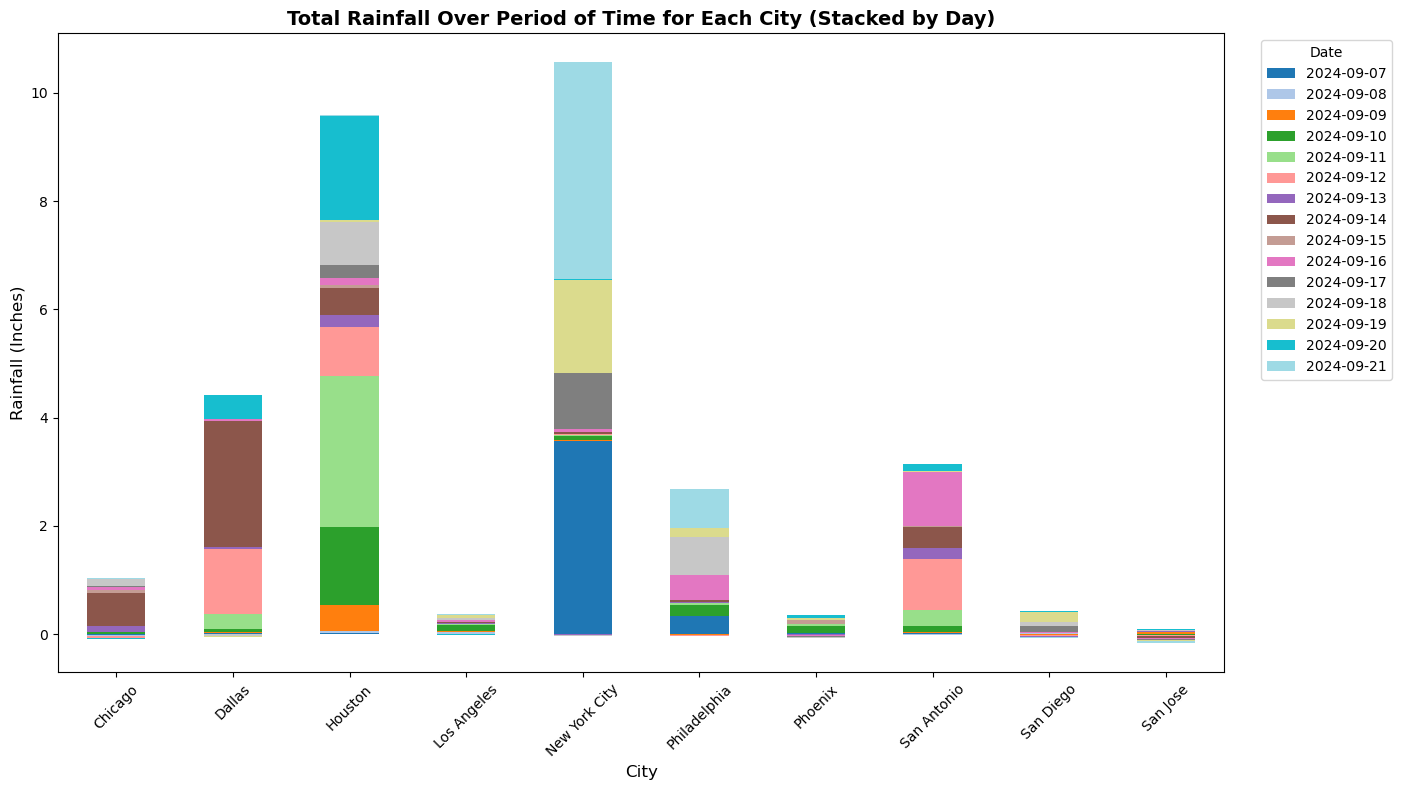

In [103]:
# Cumulative precipitation accumulation over time

# Sum up rainfall for each city over time with each day as its own segment
# Extract date from datetime
weather_df['date'] = pd.to_datetime(weather_df['datetime']).dt.date

# Group by City and date, sum precipitation for each day
daily_precip = weather_df.groupby(['City', 'date'])['precip'].sum().reset_index()

# Pivot the data so each day becomes a column
pivot_data = daily_precip.pivot(index='City', columns='date', values='precip').fillna(0)

# Plot stacked bars for total rainfall by day
ax = pivot_data.plot(kind='bar', stacked=True, figsize=(14, 8), colormap='tab20')
ax.set_title('Total Rainfall Over Period of Time for Each City (Stacked by Day)', fontsize=14, fontweight='bold')
ax.set_xlabel('City', fontsize=12)
ax.set_ylabel('Rainfall (Inches)', fontsize=12)
ax.legend(title='Date', loc='upper right', bbox_to_anchor=(1.15, 1))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Wind

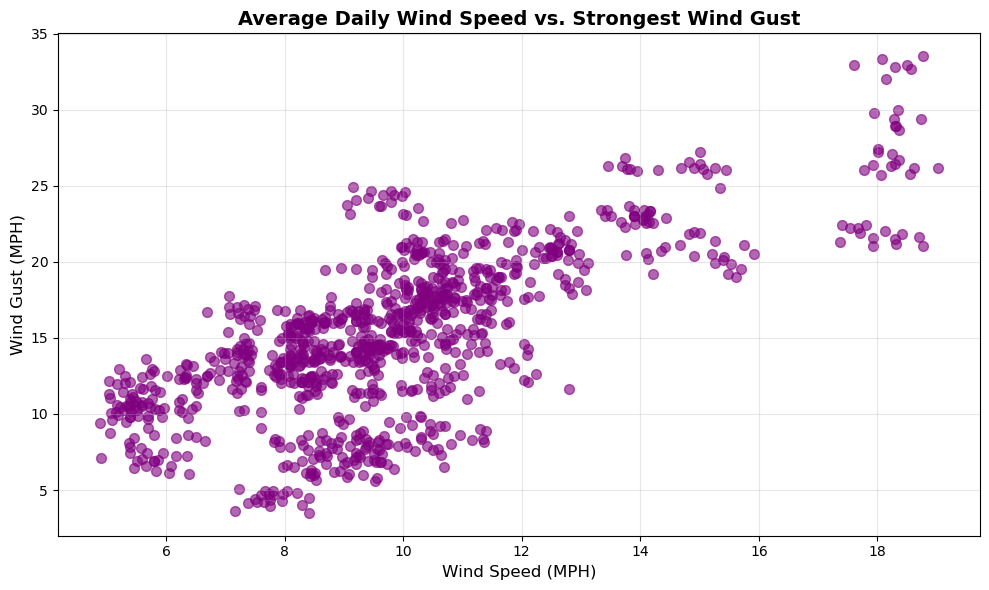

In [104]:
# Correlation Analysis for Wind

# Scatter plot: Wind speed (average) vs. strongest wind gust
fig, ax = plt.subplots(figsize=(10, 6))
scatter = ax.scatter(weather_df['windspeed'], weather_df['windgust'], 
                    c='purple', alpha=0.6, s=50)
ax.set_xlabel('Wind Speed (MPH)', fontsize=12)
ax.set_ylabel('Wind Gust (MPH)', fontsize=12)
ax.set_title('Average Daily Wind Speed vs. Strongest Wind Gust', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Cloud Coverage & Visibility

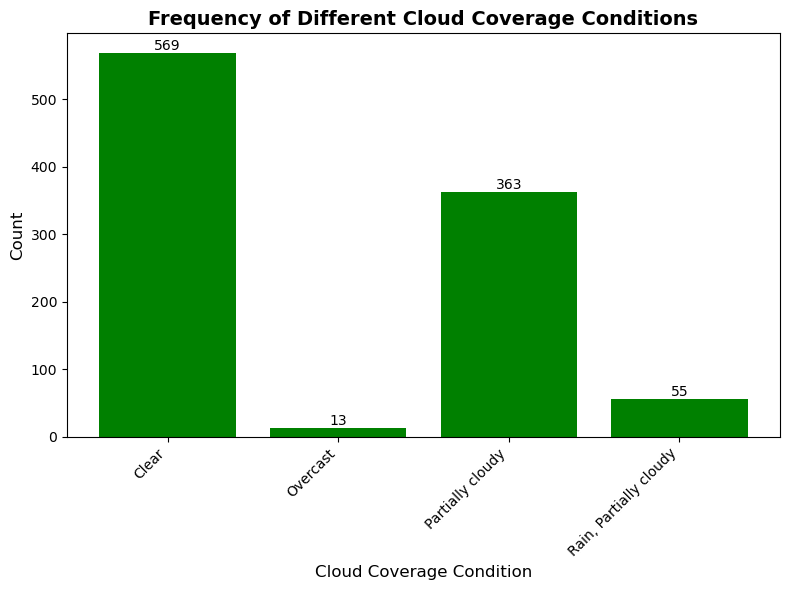

In [105]:
# Count of Days by Cloud Coverage Category

# Bar Chart for count of each cloud coverage category (clear, partly cloud, overcast)
fig, ax = plt.subplots(figsize=(8, 6))
condition_counts = (
    weather_df['conditions']
      .value_counts(dropna=False)
      .sort_index()
)
condition_counts.index = condition_counts.index.map(lambda val: 'Missing' if pd.isna(val) else val)

bars = ax.bar(condition_counts.index.astype(str), condition_counts.values, color='green')
ax.set_title('Frequency of Different Cloud Coverage Conditions', fontsize=14, fontweight='bold')
ax.bar_label(bars)
ax.set_xlabel('Cloud Coverage Condition', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

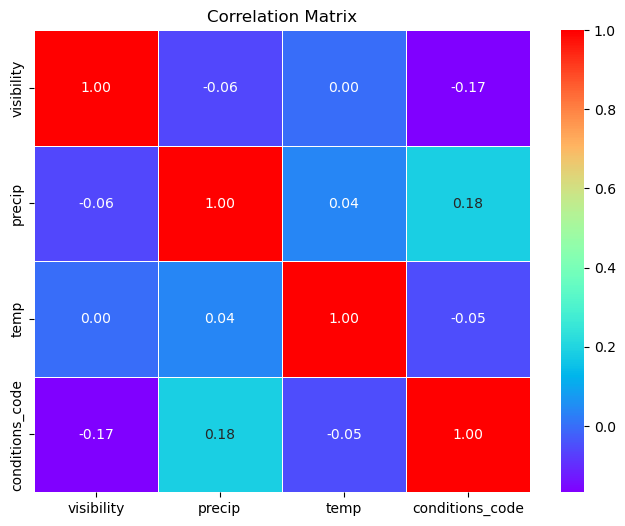

In [106]:
# Show relationship between cloud coverage, visibility, precipitation, and temperature

# Correlation matrix
variables = ['conditions', 'visibility', 'precip', 'temp']
df_subset = weather_df[variables].copy()

# Encode weather condition strings as integers
condition_codes, condition_labels = pd.factorize(df_subset['conditions'])
df_subset['conditions_code'] = condition_codes.astype(float)  # -1 for NaN; coerces to NaN

# Drop the original text column so only numeric columns remain
df_subset = df_subset.drop(columns='conditions')

correlation_matrix = df_subset.corr()
plt.figure(figsize=(8, 6)) # Adjust figure size as needed
sns.heatmap(correlation_matrix, annot=True, cmap='rainbow', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix')
plt.show()

## Sunrise, Sunset & Moon Phases

In [112]:
# Display the sunrise and sunset times for each day and city in the dataset.

# Earliest & Latest Sunrise & Sunset Times Data Table
sunset_sunrise_data = (
    weather_df[['City', 'datetime', 'sunrise', 'sunset']]
    .dropna(subset=['sunrise', 'sunset'])
    .copy()
)

if sunset_sunrise_data.empty:
    print("No sunrise/sunset information available.")
else:
    sunset_sunrise_data['date'] = pd.to_datetime(sunset_sunrise_data['datetime']).dt.date
    sunset_sunrise_data['sunrise_time'] = pd.to_datetime(sunset_sunrise_data['sunrise']).dt.strftime('%H:%M:%S')
    sunset_sunrise_data['sunset_time'] = pd.to_datetime(sunset_sunrise_data['sunset']).dt.strftime('%H:%M:%S')
        
    print("\nSummary by City:")
    summary_data = sunset_sunrise_data.groupby('City').agg({
        'sunrise': ['min', 'max'],
        'sunset': ['min', 'max']
    })
    summary_data.columns = ['Earliest Sunrise', 'Latest Sunrise', 'Earliest Sunset', 'Latest Sunset']
    summary_data = summary_data.reset_index()
    summary_data['Earliest Sunrise'] = pd.to_datetime(summary_data['Earliest Sunrise']).dt.strftime('%H:%M:%S')
    summary_data['Latest Sunrise'] = pd.to_datetime(summary_data['Latest Sunrise']).dt.strftime('%H:%M:%S')
    summary_data['Earliest Sunset'] = pd.to_datetime(summary_data['Earliest Sunset']).dt.strftime('%H:%M:%S')
    summary_data['Latest Sunset'] = pd.to_datetime(summary_data['Latest Sunset']).dt.strftime('%H:%M:%S')

    styled_city_data = (
        summary_data.style
        .set_caption("Detailed Sunrise/Sunset Times")
        .set_table_styles([
            {'selector': 'th', 'props': [('background-color', '#F54927'), ('color', 'black')]},
            {'selector': 'caption', 'props': [('font-size', '16pt'), ('font-weight', 'bold')]}
        ])
        .hide(axis="index") # Hide the default pandas index
    )

    display(styled_city_data)


Summary by City:


City,Earliest Sunrise,Latest Sunrise,Earliest Sunset,Latest Sunset
Chicago,06:23:01,06:37:29,18:48:38,19:12:59
Dallas,07:06:06,07:15:05,19:24:32,19:43:25
Houston,07:02:12,07:09:37,19:18:39,19:35:58
Los Angeles,06:31:08,06:40:49,18:50:20,19:09:54
New York City,06:29:24,06:43:05,18:54:06,19:17:40
Philadelphia,06:34:37,06:47:48,18:58:38,19:21:42
Phoenix,06:06:50,06:16:10,18:25:39,18:44:53
San Antonio,07:14:53,07:22:09,19:31:08,19:48:16
San Diego,06:27:38,06:36:35,18:45:55,19:04:46
San Jose,06:43:31,06:55:05,19:05:06,19:26:34


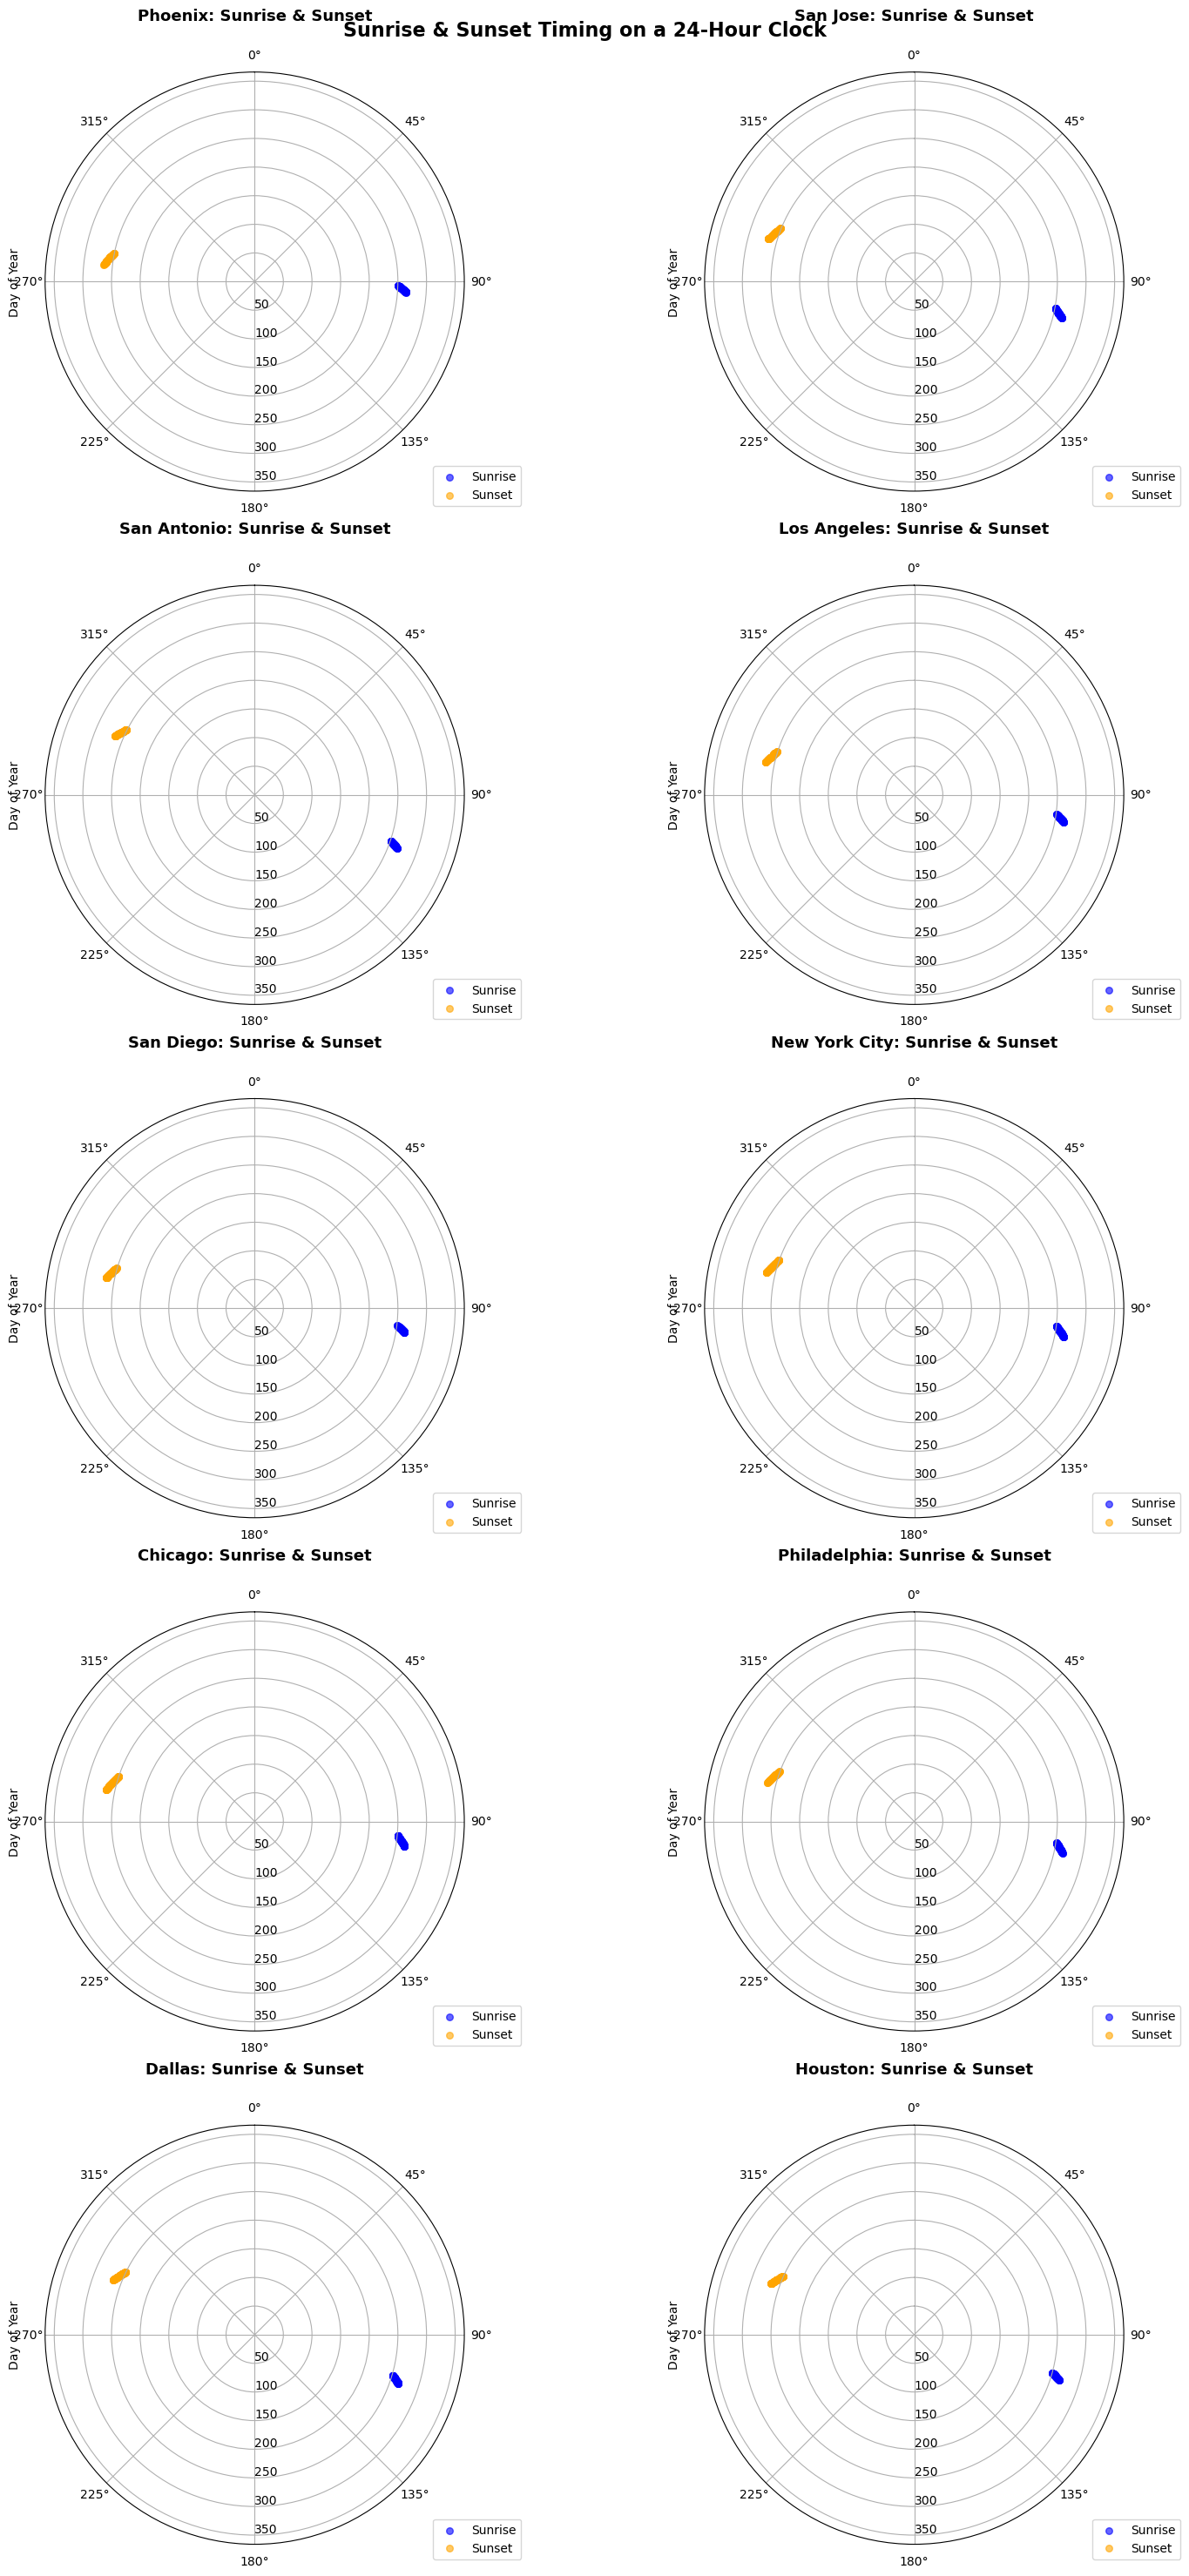

In [108]:
# Visualize sunrise and sunset timing for every city on a 24-hour clock while the radial axis tracks progression through the year (day-of-year).

# Polar Plot: Sunrise & Sunset by City
sun_cycles = (
    weather_df[['City', 'datetime', 'sunrise', 'sunset']]
    .dropna(subset=['sunrise', 'sunset'])
    .copy()
)

if sun_cycles.empty:
    print("No sunrise/sunset information available to plot.")
else:
    sun_cycles['day_of_year'] = sun_cycles['datetime'].dt.dayofyear

    def _angle_from_time(series):
        hours = series.dt.hour.fillna(0)
        minutes = series.dt.minute.fillna(0)
        seconds = series.dt.second.fillna(0)
        fractional_hours = hours + minutes / 60 + seconds / 3600
        return 2 * np.pi * (fractional_hours / 24)

    sun_cycles['sunrise_angle'] = _angle_from_time(sun_cycles['sunrise'])
    sun_cycles['sunset_angle'] = _angle_from_time(sun_cycles['sunset'])

    cities = sun_cycles['City'].unique()
    n_cities = len(cities)
    n_cols = 2 if n_cities > 1 else 1
    n_rows = int(np.ceil(n_cities / n_cols))

    fig_width = 16 if n_cols == 2 else 12
    fig_height = max(6 * n_rows, 8)
    fig, axes = plt.subplots(
        n_rows,
        n_cols,
        subplot_kw={'projection': 'polar'},
        figsize=(fig_width, fig_height)
    )
    axes = axes.flatten() if n_cities > 1 else [axes]

    for idx, city in enumerate(cities):
        ax = axes[idx]
        city_data = sun_cycles[sun_cycles['City'] == city]
        radius = city_data['day_of_year']
        ax.scatter(city_data['sunrise_angle'], radius, color='blue', alpha=0.6, s=30, label='Sunrise')
        ax.scatter(city_data['sunset_angle'], radius, color='orange', alpha=0.6, s=30, label='Sunset')
        ax.set_title(
            f"{city}: Sunrise & Sunset",
            fontsize=13,
            fontweight='bold',
            pad=15,
            y=1.08
        )
        ax.set_theta_zero_location('N')  # Midnight at top
        ax.set_theta_direction(-1)       # Clockwise
        ax.set_rlabel_position(180)
        ax.set_ylabel('Day of Year', labelpad=20)
        ax.set_rlim(0, 366)
        ax.tick_params(axis='y', pad=10)
        ax.legend(loc='lower right', bbox_to_anchor=(1.15, -0.05))

    for idx in range(n_cities, len(axes)):
        axes[idx].set_visible(False)

    plt.suptitle('Sunrise & Sunset Timing on a 24-Hour Clock', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()


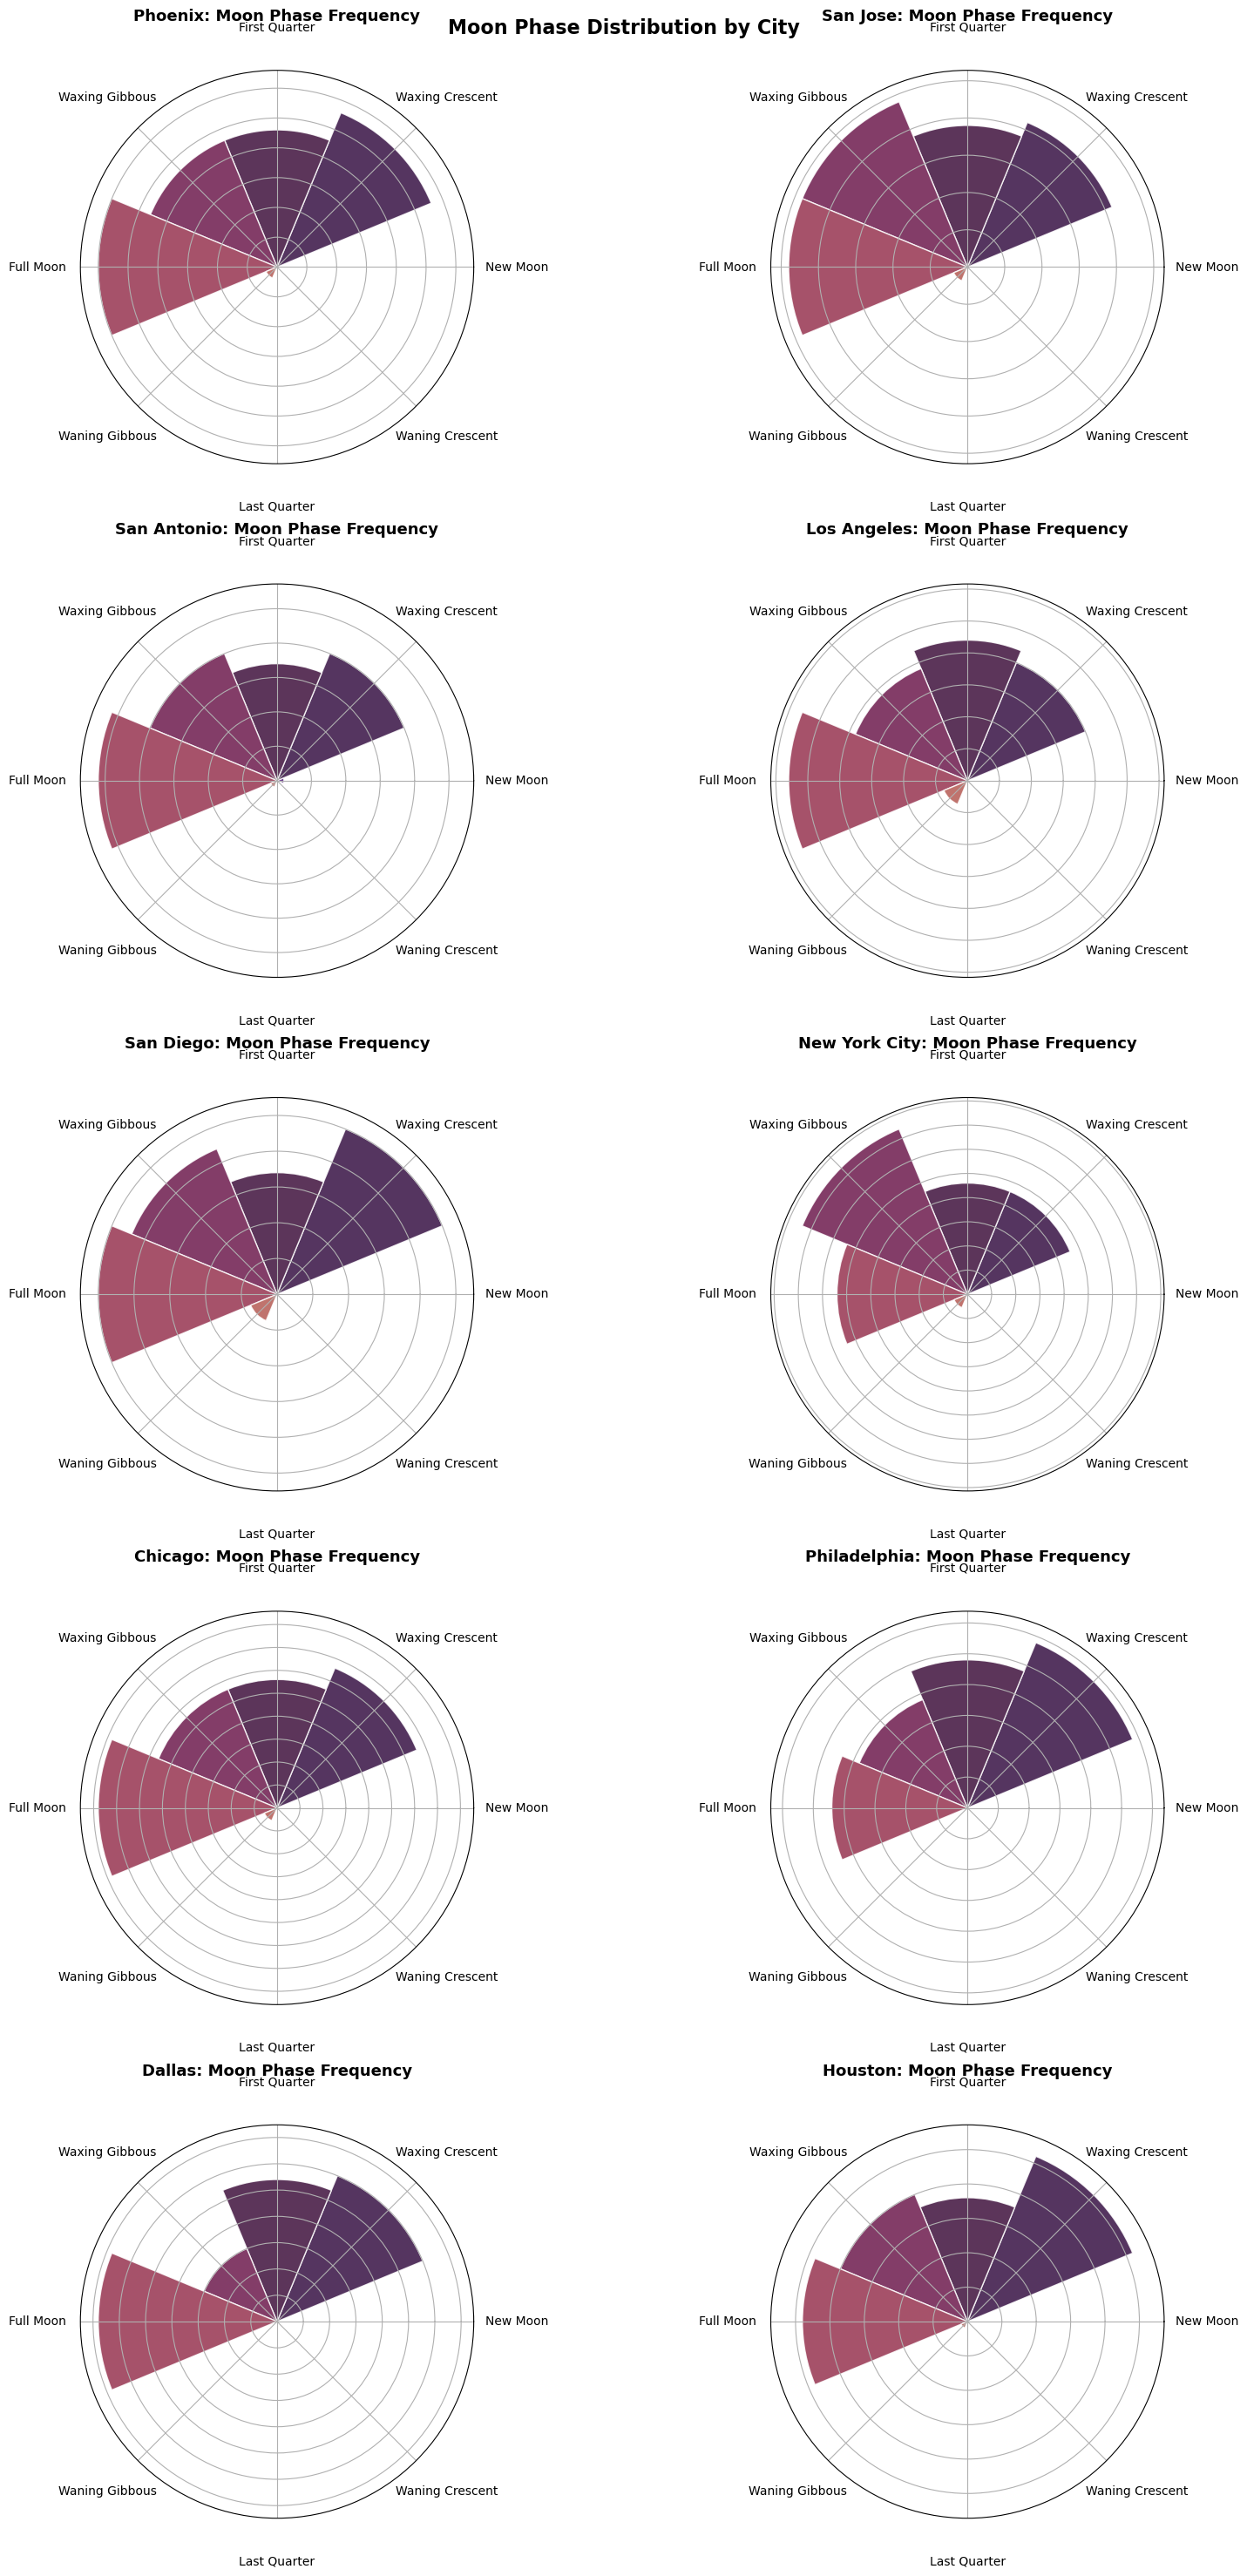

In [109]:
# Show how often each moon phase occurs per city using radial bars positioned around the lunar cycle.

# Circular Bar Chart: Moon Phase Distribution
moon_df = weather_df[['City', 'moonphase']].dropna().copy()

if moon_df.empty:
    print("Moon phase data is missing; skipping radial bar chart.")
else:
    phase_bins = [0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1.01]
    phase_labels = [
        'New Moon', 'Waxing Crescent', 'First Quarter', 'Waxing Gibbous',
        'Full Moon', 'Waning Gibbous', 'Last Quarter', 'Waning Crescent'
    ]

    moon_df['phase'] = pd.cut(
        moon_df['moonphase'],
        bins=phase_bins,
        labels=phase_labels,
        include_lowest=True,
        right=False
    )

    phase_counts = (
        moon_df.groupby(['City', 'phase'], observed=False)
        .size()
        .reset_index(name='count')
    )

    cities = moon_df['City'].unique()
    n_cities = len(cities)
    n_cols = 2 if n_cities > 1 else 1
    n_rows = int(np.ceil(n_cities / n_cols))
    angles = np.linspace(0, 2 * np.pi, len(phase_labels), endpoint=False)
    width = (2 * np.pi) / len(phase_labels)

    fig_width = 16 if n_cols == 2 else 12
    fig_height = max(6 * n_rows, 8)
    fig, axes = plt.subplots(
        n_rows,
        n_cols,
        subplot_kw={'projection': 'polar'},
        figsize=(fig_width, fig_height)
    )
    axes = axes.flatten() if n_cities > 1 else [axes]

    for idx, city in enumerate(cities):
        ax = axes[idx]
        city_counts = (
            phase_counts[phase_counts['City'] == city]
            .set_index('phase')
            .reindex(phase_labels, fill_value=0)
        )
        counts = city_counts['count'].values
        colors = plt.cm.twilight(np.linspace(0.4, 0.9, len(counts)))
        ax.bar(angles, counts, width=width, color=colors, alpha=0.85, edgecolor='white', linewidth=1)
        ax.set_xticks(angles)
        ax.set_xticklabels(phase_labels, fontsize=10)
        ax.set_yticklabels([])
        ax.set_ylim(0, counts.max() * 1.1 if counts.max() > 0 else 1)
        ax.set_title(
            f"{city}: Moon Phase Frequency",
            fontsize=13,
            fontweight='bold',
            pad=15,
            y=1.08
        )
        ax.tick_params(axis='x', pad=25)

    for idx in range(n_cities, len(axes)):
        axes[idx].set_visible(False)

    plt.suptitle('Moon Phase Distribution by City', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
